<a href="https://colab.research.google.com/github/mekhi-woods/HiloCATsSN1991bg/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [697]:
# """ DEPRICATED FUNCTIONS """
# def plot_91bglike_SN1a(FILTER_WHEEL = ['u', 'g', 'r', 'i', 'B', 'V0']):
    # KrisciunasPath = "/content/HiloCATsSN1991bg/targetLists/91bglike_justnames.txt"
    # KrisciunasNames = np.genfromtxt(KrisciunasPath, dtype=str, delimiter=', ')

    # allCPSPhot = "/content/HiloCATsSN1991bg/data/CSPdata/SN_photo.dat"
    # allCPSPhotData = np.genfromtxt(allCPSPhot, dtype='str')

    # names = allCPSPhotData[:,0]
    # filters = allCPSPhotData[:,1]
    # time = allCPSPhotData[:,2]
    # light = allCPSPhotData[:,3]
    # err = allCPSPhotData[:,4]

    # plt.figure(figsize=(10,6))
    # sigma = 1
    # for tar in KrisciunasNames:
    #     for n in range(len(FILTER_WHEEL)):
    #         # output_names = names[(names == tar) & (filters == FILTER_WHEEL[n])]
    #         output_light = light[(names == tar) & (filters == FILTER_WHEEL[n])].astype('float64')
    #         output_time = time[(names == tar) & (filters == FILTER_WHEEL[n])].astype('float64') + 53000
    #         output_err = err[(names == tar) & (filters == FILTER_WHEEL[n])].astype('float64')
    #         plt.errorbar(output_time, output_light, yerr=output_err*sigma, fmt='o', label=FILTER_WHEEL[n])

    #     plt.title(tar); plt.xlabel('Time [MJD]'); plt.ylabel('Intensity [mag]')
    #     plt.gca().invert_yaxis()
    #     plt.legend()
    #     # plt.savefig('save\\'+str(tar)+'.png')
    #     plt.show()
    #     break
    # return

# def plot_DR3_tmax_st_EBVhost():
    # data = np.genfromtxt('/content/HiloCATsSN1991bg/DR3_fits.dat', dtype=str, skip_header=1)
    # DR3_st = np.stack((data[:, 1].astype(float), data[:, 2].astype(float)), axis=1)
    # DR3_Tmax = np.stack((data[:, 5].astype(float), data[:, 6].astype(float)), axis=1)
    # DR3_EBVhost = np.stack((data[:, 25].astype(float), data[:, 26].astype(float)), axis=1)

    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
    # fig.suptitle("DR3's Tmax vs. st vs EBVhost")
    # sigmas = [[1, 1], [1, 1], [1, 1]]

    # # Tmax vs. st
    # ax1.errorbar(DR3_Tmax[:, 0], DR3_st[:, 0],
    #              xerr=DR3_Tmax[:, 1]*sigmas[0][0], yerr=DR3_st[:, 1]*sigmas[0][1],
    #              fmt='yo')
    # ax1.set_xlabel('Tmax'); ax1.set_ylabel('st')
    # ax1.set_title('Tmax vs. st, sigma(x='+str(sigmas[0][0])+', y='+str(sigmas[0][1])+')')

    # # st vs. EBVhost
    # ax2.errorbar(DR3_st[:, 0], DR3_EBVhost[:, 0],
    #              xerr=DR3_st[:, 1]*sigmas[1][0], yerr=DR3_EBVhost[:, 1]*sigmas[1][1],
    #              fmt='bo')
    # ax2.set_xlabel('st'); ax2.set_ylabel('EBVhost')
    # ax2.set_title('st vs. EBVhost, sigma(x='+str(sigmas[1][0])+', y='+str(sigmas[1][1])+')')

    # # Tmax vs. EBVhost
    # ax3.errorbar(DR3_Tmax[:, 0], DR3_EBVhost[:, 0],
    #              xerr=DR3_Tmax[:, 1]*sigmas[2][0], yerr=DR3_EBVhost[:, 1]*sigmas[2][1],
    #              fmt='ro')
    # ax3.set_xlabel('Tmax'); ax3.set_ylabel('EBVhost')
    # ax3.set_title('Tmax vs. EBVhost, sigma(x='+str(sigmas[2][0])+', y='+str(sigmas[2][1])+')')

    # plt.show()
    # return

# def snpy_fit(filePath, model='max_model', shapeParam='dm15', BandsToFit = ['B','g','r','i'], summarize=True, saveplots=False, saveLoc=ATLAS_SNPY_PLOTS_PATH, show_plots=True):
    # s = snpy.get_sn(filePath)

    # # Set model parameters
    # s.choose_model(model, stype=shapeParam)
    # s.set_restbands() # Auto pick appropriate rest-bands

    # # Fit data -- using David configurations
    # fitargs = {'mangle':1,'calibration':0, 'quiet':False} # I don't remember what calibration is
    # s.fit(BandsToFit,
    #       dokcorr=True,
    #       k_stretch=False,
    #       reset_kcorrs=True,
    #       **fitargs)

    # # Show results
    # if summarize:
    #     s.summary()
    #     # for param in s.parameters:
    #     #     print("{} = {} +/- {}".format(param, s.parameters[param], s.errors[param]))
    # if saveplots:
    #     print('Plot saved to', ATLAS_SNPY_PLOTS_PATH+filePath[-17:-9]+'_snpyplots.png')
    #     s.plot(outfile=ATLAS_SNPY_PLOTS_PATH+filePath[-17:-9]+'_snpyplots.png')
    #     if show_plots:
    #         plt.show()
    #     else:
    #         plt.close()

    #     with ZipFile(ATLAS_SNPY_PLOTS_PATH+'snpyplots.zip', 'a') as zip_object:
    #         zip_object.write(ATLAS_SNPY_PLOTS_PATH+filePath[-17:-9]+'_snpyplots.png')

    # return s

# def SNooPy2_fitting(dataPath, tarNames, model='EBV_model2', shape='st', bands=['B','g','r','i'], output=False, snpyPlots=False, show_plots=True, use_saved=True):
    # PROBLEM_CHILDREN = []

    # if len(bands) == 0:
    #     bands = None

    # tarPaths = []
    # for tar in tarNames:
    #     tarPaths.append(dataPath+str(tar))

    # SNe_mu = {}
    # SNe_z = {}
    # SNe_params = {}

    # for i in range(len(tarPaths)):
    #     tarName = tarNames[i][:-9]
    #     tarSave = MODELS_PATH+tarName+'_'+model+'.snpy'
    #     print('[ '+str(i+1)+' / '+str(len(tarPaths))+'] Fiting data for '+tarName+'...')

    #     # Create/Retrieve Fit
    #     valid = True

    #     if os.path.exists(tarSave) and use_saved:
    #         print(tarName, 'found in files! Pulling data...')
    #         s_n = snpy.get_sn(tarSave)
    #     elif os.path.exists(tarPaths[i]):
    #         try:
    #             s_n = snpy_fit(tarPaths[i],
    #                             model=model,
    #                             shapeParam=shape,
    #                             BandsToFit=None,
    #                             summarize=output,
    #                             saveplots=snpyPlots,
    #                             saveLoc=ATLAS_SNPY_PLOTS_PATH,
    #                             show_plots=show_plots) # Enter snpy fit function
    #         except ValueError:
    #             PROBLEM_CHILDREN.append(tarName)
    #             print('[!!!] ValueError: No data near maximum light... skipping\n')
    #             valid = False
    #         except RuntimeError:
    #             PROBLEM_CHILDREN.append(tarName)
    #             print('[!!!] RuntimeError: Model has trailed off fitting filter... skipping\n')
    #             valid = False
    #         except TypeError:
    #             PROBLEM_CHILDREN.append(tarName)
    #             print('[!!!] TypeError: m > k must hold (I have no clue what this means)... skipping\n')
    #             valid = False
    #         except:
    #             PROBLEM_CHILDREN.append(tarName)
    #             print('[!!!] Unknown Error... skipping\n')
    #             valid = False
    #     else:
    #         print(tarName, 'does not exsist in CSP data... skipping')
    #         valid = False

    #     if valid:
    #         # Save model
    #         s_n.save(tarSave)

    #         # Pull SNooPY distance
    #         snpy_mu = s_n.get_distmod() # Nab paramaters from SNe objects)

    #         # Update dictionary/list
    #         SNe_mu.update({tarName: snpy_mu})
    #         SNe_z.update({tarName: s_n.z})
    #         SNe_params.update({tarName: [s_n.st, s_n.Tmax, s_n.EBVhost, s_n.DM]})

    #         # Print info
    #         print('Redshift:\t z = '+str(s_n.z))
    #         print('Distance: \t mu = '+str(round(snpy_mu, 4))+'\n')

    # print('Problem children:\n', '[', len(PROBLEM_CHILDREN), ']', PROBLEM_CHILDREN)
    # plt.close()
    # return SNe_mu, SNe_z, SNe_params

# def ztf_query(targets, jds, jde):
    # print("Number of (ra, dec) pairs =", len(targets))

    # ralist = []
    # declist = []
    # i = 0
    # for tar in targets:
    #     raval = float('%.7f'%(float(tar[0])))
    #     decval = float('%.7f'%(float(tar[1])))
    #     ralist.append(raval)
    #     declist.append(decval)
    #     i = i + 1
    #     rem = i % 1500 # Limit submission to 1500 sky positions.
    #     if rem == 0:
    #         ztf_submit_post(ralist, declist, jds, jde)
    #         ralist = []
    #         declist = []
    # if len(ralist) > 0:
    #     ztf_submit_post(ralist, declist, jds, jde)
    # return

# def ATLAS_snpy_fitting(SNe, ATLASnames, show_plot=True, use_saved=True):
    # SNe_mu, SNe_z, SNe_params = SNooPy2_fitting(ATLAS_SNPY_DATA_PATH,
    #                                             ATLASnames,
    #                                             model='EBV_model2', shape='st', bands=['ATri', 'ATgr'],
    #                                             output=True, snpyPlots=True, show_plots=show_plot, use_saved=use_saved)
    # SNe_new = []
    # for SN in SNe:
    #     try:
    #         SN.mu = SNe_mu[SN.objname]
    #         SN.z = SNe_z[SN.objname]
    #         SN.st = SNe_params[SN.objname][0]
    #         SN.Tmax = SNe_params[SN.objname][1]
    #         SN.EBVhost = SNe_params[SN.objname][2]
    #         SN.DM = SNe_params[SN.objname][3]
    #         SNe_new.append(SN)
    #     except KeyError:
    #         print(SN.objname, 'is a problem child, removing...')

    # # Save distance mod
    # params = np.genfromtxt(ROOT_SAVE+'ATLAS_variables.txt', delimiter=', ', dtype=str, skip_header=1)
    # with open(ROOT_SAVE+'ATLAS_variables_mu.txt', 'w') as f:
    #     f.write('objname, ATLASname, RA, DEC, z, tmin, tmax, mu\n')
    #     for n in range(len(SNe_new)):
    #         f.write(str(params[n, 0])+', '+str(params[n, 1])+', '+str(params[n, 2])+', '+str(params[n, 3])+', '+
    #                 str(params[n, 4])+', '+str(params[n, 5])+', '+str(params[n, 6])+', '+str(SNe_new[n].mu)+'\n')

    # return SNe_new

# def ATLAS_main_processing(err_max=100, yaxis='flux', t_lim = 0.1, n_iter = 0, plot_mode = 'SOLO', show_plot=True, use_saved=True):
    # # [2.1] Aquire Data
    # print('[2.1] Retrieving data from...', ATLAS_DATA_PATH)
    # files = glob.glob(ATLAS_DATA_PATH+'/*')
    # PROBLEM_CHILDREN = ['1032212120425304400']   # Running list of problematic SNe
    #                                             # '1032212120425304400' - David believes it might be a shock breakout but ATLAS reports it as SN1a
    #                                             #
    # # [2.2] Validate Data
    # print('[2.2] Sorting data...')
    # SNe = []
    # for n in range(len(files)):
    #     print('[', n+1, '/', len(files), '] Validating data for...', files[n][48:-4])
    #     result = slice_data(path=files[n], err_max=err_max)
    #     if result != None:
    #         SNe.append(result)
    #     else:
    #         PROBLEM_CHILDREN.append(files[n][48:-4])
    #     if n_iter != 0 and n+1 >= n_iter:
    #         break

    # # [2.3] Remove problem children
    # print('[2.3] Problem Children: ', PROBLEM_CHILDREN)
    # for SN in SNe:
    #     for probname in PROBLEM_CHILDREN:
    #         if SN.ATLASname == probname:
    #             print('Removing...', SN.ATLASname)

    # # [2.4] Save RA, DEC, Redshift, and Object Name
    # print('[2.4] Saving parameters to file...')
    # print(t_lim, 'second pause between entries...')
    # TNS_obj_detection(SNe, t_lim=t_lim, use_saved=use_saved)

    # # [2.5] Plot data
    # if plot_mode == 'SOLO':
    #     print("[2.5] Plotting data [indivisual]...")
    #     with ZipFile(ATLAS_PLOTS_PATH+'/ATLASplots.zip', 'w') as zip_object:
    #         for SN in SNe:
    #             solo_plotting(name=SN.ATLASname, coords=[SN.RA, SN.DEC], err_max=err_max,
    #                           t_o=SN.t_o, flux_o=SN.flux_o, flux_err_o=SN.dflux_o,
    #                           t_c=SN.t_c, flux_c=SN.flux_c, flux_err_c=SN.dflux_c,
    #                           save=True, saveLoc=ATLAS_PLOTS_PATH, show_plot=show_plot)
    #             zip_object.write(ATLAS_PLOTS_PATH+SN.ATLASname+'_ATLASplot.png')
    #             print('Plot saved to', ATLAS_PLOTS_PATH+SN.ATLASname+'_ATLASplot.png')
    # elif plot_mode == 'COMBINED':
    #     print("[2.5] Plotting data [combined]...")
    #     fig, axs = plt.subplots(len(SNe), figsize=(12, len(SNe)*3.2))
    #     fig.tight_layout(pad=5.0)
    #     for n in range(len(SNe)):
    #         combined_plotting(ax=axs[n], name=SN.ATLASname, coords=[SN.RA, SN.DEC],
    #                           t_o=SNe[n].t_o, flux_o=SNe[n].flux_o, flux_err_o=SNe[n].dflux_o,
    #                           t_c=SN.t_c, flux_c=SN.flux_c, flux_err_c=SN.dflux_c)
    #     plt.savefig(ATLAS_PLOTS_PATH+'CombinedATLASplots.png')
    #     print('Plot saved to', ATLAS_PLOTS_PATH+'CombinedATLASplots.png')
    #     if show_plot:
    #         plt.show()
    #     else:
    #         plt.close()

    # return SNe

# def snpy_ASCII_formatting(SNe):
    # knownVariables = {}
    # skip_header = True
    # with open(ROOT_SAVE+'ATLAS_variables.txt', 'r') as f:
    #     for line in f.readlines():
    #         if skip_header:
    #             skip_header = False
    #             pass
    #         else:
    #             line = line[:-1].split(', ')
    #             name = line[1]
    #             line.remove(name)
    #             knownVariables.update({name : line})

    # ATLASnames = []
    # for SN in SNe:
    #     ATLASnames.append(str(SN.objname)+'_snpy.txt')
    #     with open(ATLAS_SNPY_DATA_PATH+str(SN.objname)+'_snpy.txt', 'w') as f:
    #         # Line 1
    #         # Ex. SN1981D 0.005871 50.65992 -37.23272
    #         #     Name    Helio Z  RA        Dec
    #         try:
    #             SN.objname = knownVariables[SN.ATLASname][0]
    #         except KeyError:
    #             print('No saved data for...', SN.ATLASname)
    #         f.write(str(SN.objname)+' '+str(SN.z)+' '+str(SN.RA)+' '+str(SN.DEC)+'\n')
    #         print(str(SN.objname)+' '+str(SN.z)+' '+str(SN.RA)+' '+str(SN.DEC))

    #         # 'ATri'-filter photometry block
    #         # Ex. filter O
    #         #     674.8593      12.94   0.11
    #         #     Date (JD/MJD) mag     err
    #         f.write('filter ATri\n')
    #         for i in range(len(SN.t_o)):
    #             f.write(str(SN.t_o[i])+'\t'+str(SN.mag_o[i])+'\t'+str(SN.dmag_o[i])+'\n')

    #         # # 'ATgr'-filter photometry block
    #         f.write('filter ATgr\n')
    #         for i in range(len(SN.t_c)):
    #             f.write(str(SN.t_c[i])+'\t'+str(SN.mag_c[i])+'\t'+str(SN.dmag_c[i])+'\n')
    # return ATLASnames

# def data_collection(path=ATLAS_DATA_PATH, quiet=False):
        # if os.path.exists(ROOT_SAVE+'tmp.npz'):
        #     pickle = np.load(ROOT_SAVE+'tmp.npz', allow_pickle=True)
        #     data = pickle['data']

        # data = requests.post(
        #     'https://star.pst.qub.ac.uk/sne/atlas4/api/objectlist/',
        #     headers={'Authorization': f'Token {API_TOKEN}'},
        #     data={'objectlistid':2}
        # ).json()

        # np.savez(ROOT_SAVE+'tmp.npz', data=data)

        # count = 0
        # for d in data:
        #     if d['observation_status'] is not None and d['observation_status'].startswith('SN Ia') and '91bg' in d['observation_status']:
        #         count += 1
        #         if not quiet:
        #             print(d['atlas_designation'],d['observation_status'].replace(' ',''),d['ra'],d['dec'])


        #         ids = d['id']
        #         base_url = 'https://star.pst.qub.ac.uk/sne/atlas4/lightcurveforced/1161048951013729300/'
        #         new_url = base_url.replace('1161048951013729300/',str(ids))
        #         if not quiet:
        #             print(new_url)

        #         idfile = path+'/' + str(ids)+'.txt'
        #         if os.path.exists(idfile):
        #             continue
        #         urllib.request.urlretrieve(str(new_url), str(idfile))
        #         if not quiet:
        #             print(idfile)

        #     if count > 300:
        #         break

# def slice_data(path, err_max=100):
    # name = path[48:-4]
    # data = np.genfromtxt(path, dtype=str, delimiter=',')

    # if len(data) == 0:
    #     print('[!!!] File '+name+' empty...skipping')
    #     return None

    # filters = data[:, 6]
    # t = data[:, 8].astype(float)
    # flux = data[:, 24]
    # dflux = data[:, 25]
    # mag = np.char.replace(data[:, 3], '>', '') # Removes greater than symbols
    # dmag = data[:, 4]

    # # Finds the empty spots of flux and mag and records the element
    # mod_empty = np.unique(np.hstack((np.hstack((np.where(flux == 'None')[0], np.where(dflux == 'None')[0])),
    #                                  np.hstack((np.where(mag == 'None')[0], np.where(dmag == 'None')[0])))))
    # filters = np.delete(filters, mod_empty)
    # t = np.delete(t, mod_empty).astype(float)
    # flux = np.delete(flux, mod_empty).astype(float)
    # dflux = np.delete(dflux, mod_empty).astype(float)
    # mag = np.delete(mag, mod_empty).astype(float)
    # dmag = np.delete(dmag, mod_empty).astype(float)

    # # Finds negative fluxes
    # mod_positive = np.unique(np.hstack((np.hstack((np.where(flux <= 0)[0], np.where(dflux <= 0)[0])),
    #                             np.hstack((np.where(mag <= 0)[0], np.where(dmag <= 0)[0])))))
    # filters = np.delete(filters, mod_positive)
    # t = np.delete(t, mod_positive)
    # flux = np.delete(flux, mod_positive)
    # dflux = np.delete(dflux, mod_positive)
    # mag = np.delete(mag, mod_positive)
    # dmag = np.delete(dmag, mod_positive)

    # # Find outliers beyond error limit
    # mod_err = np.unique(np.hstack(((np.where(abs(dflux) > err_max)[0]), np.where(abs(dmag) > err_max)[0]))) # Negatives fluxes & Error Limit
    # filters = np.delete(filters, mod_err)
    # t = np.delete(t, mod_err)
    # flux = np.delete(flux, mod_err)
    # dflux = np.delete(dflux, mod_err)
    # mag = np.delete(mag, mod_err)
    # dmag = np.delete(dmag, mod_err)

    # tempSN = ATLAS_SN(ATLASname=name, RA=np.average(data[:, 1].astype(float)), DEC=np.average(data[:, 2].astype(float)),
    #                     t_o=t[np.where(filters=='o')[0]], flux_o=flux[np.where(filters=='o')[0]], dflux_o=dflux[np.where(filters=='o')[0]], mag_o=mag[np.where(filters=='o')[0]], dmag_o=dmag[np.where(filters=='o')[0]],
    #                     t_c=t[np.where(filters=='c')[0]], flux_c=flux[np.where(filters=='c')[0]], dflux_c=dflux[np.where(filters=='c')[0]], mag_c=mag[np.where(filters=='c')[0]], dmag_c=dmag[np.where(filters=='c')[0]])

    # return tempSN

# def TNS_obj_detection(SNe, t_lim=0.1, saveLoc=ROOT_SAVE+'ATLAS_variables.txt', use_saved=True):
    # # Check for presaved data
    # savedData = {}
    # if os.path.exists(saveLoc) and use_saved:
    #     data = np.genfromtxt(saveLoc, delimiter=', ', dtype=str, skip_header=1)
    #     if len(data) > 0:
    #         for n in range(len(data[:, 0])):
    #             savedData.update({data[n][1]: [data[n][0], data[n][4]]})

    # with open(saveLoc, 'w') as f:
    #     f.write('objname, ATLASname, RA, DEC, z, tmin, tmax\n') # Header
    #     for n in range(len(SNe)):
    #         if SNe[n].ATLASname in savedData:
    #             obj = {'objname' : savedData[SNe[n].ATLASname][0], 'redshift' : savedData[SNe[n].ATLASname][1]}
    #             SNe[n].objname = obj['objname']
    #             SNe[n].z = obj['redshift']
    #             print("Saved object data found for "+SNe[n].ATLASname+", retrieving...")
    #         else:
    #             print("No saved data, sleeping for", t_lim, 'seconds...')
    #             time.sleep(t_lim)
    #             obj = TNS_details(ra=SNe[n].RA, dec=SNe[n].DEC)
    #             SNe[n].objname = 'SN'+obj['objname']
    #             SNe[n].z = obj['redshift']

    #         if len(SNe[n].t_o) > 0 and len(SNe[n].t_c) > 0:
    #             t_max = max([np.max(SNe[n].t_o), np.max(SNe[n].t_c)])
    #             t_min = min([np.min(SNe[n].t_o), np.min(SNe[n].t_c)])
    #         elif len(SNe[n].t_o) == 0:
    #             t_max = np.max(SNe[n].t_c)
    #             t_min = np.min(SNe[n].t_c)
    #         elif len(SNe[n].t_c) == 0:
    #             t_max = np.max(SNe[n].t_o)
    #             t_min = np.min(SNe[n].t_o)

    #         print('[ '+str(n+1)+' / '+str(len(SNe))+' ]', SNe[n].ATLASname+':', SNe[n].objname,
    #               '| z =', SNe[n].z, '| Tmin:', t_min, 'Tmax:', t_max, '\n')
    #         f.write(str(SNe[n].objname)+', '+str(SNe[n].ATLASname)+', '+str(SNe[n].RA)+', '+str(SNe[n].DEC)+
    #                 ', '+str(SNe[n].z)+', '+str(t_min)+', '+str(t_max)+'\n')

    # return

# def solo_plotting(t_o, t_c, flux_o, flux_c, flux_err_o, flux_err_c, err_max, name='Empty', coords=[0, 0], size=(12, 4), save=False, saveLoc=ATLAS_PLOTS_PATH, show_plot=True):
    # plt.figure(figsize=size)

    # plt.errorbar(t_o, flux_o, yerr=flux_err_o, fmt='o', color='orange')
    # plt.errorbar(t_c, flux_c, yerr=flux_err_c, fmt='o', color='cyan')

    # plt.title('Light Curve: '+str(name)+'\n'+str(coords[0])+', '+str(coords[1])+'\nMax Error = '+str(err_max))
    # plt.xlabel('Time [MJD]')
    # plt.ylabel('Flux [uJy]')
    # plt.ylim(0)
    # plt.savefig(saveLoc+name+'_ATLASplot.png')
    # if show_plot:
    #     plt.show()
    # else:
    #     plt.close()
    # return

# def combined_plotting(ax, t_o, t_c, flux_o, flux_c, flux_err_o, flux_err_c, name='Empty', coords=[0, 0]):
    # ax.errorbar(t_o, flux_o, yerr=flux_err_o, fmt='o', color='orange')
    # ax.errorbar(t_c, flux_c, yerr=flux_err_c, fmt='o', color='cyan')

    # ax.set_title('Light Curve: '+str(name)+'\n'+str(coords[0])+', '+str(coords[1]))
    # ax.set_xlabel('Time [MJD]')
    # ax.set_ylabel('Flux [uJy]')
    # ax.set_ylim(0)
    # return

# def plot_ATLAS(xyo, xyc, ax=plt, name='Empty', coords=[0, 0], save=False, saveloc=ATLAS_PLOTS_PATH):
    # ax.errorbar(xyo[0], xyo[1], yerr=xyo[2], fmt='o', color='orange')
    # ax.errorbar(xyc[0], xyc[1], yerr=xyc[2], fmt='o', color='cyan')

    # ax.set_title('Light Curve: '+str(name)+'\n'+str(coords[0])+', '+str(coords[1]))
    # ax.set_xlabel('Time [MJD]'); ax.set_ylabel('Flux [uJy]')
    # if save:
    #     plt.savefig(saveloc+name+'_ATLASplot.png')
    # return

# def ATLAS_process():
    # # [1] Collecting ATLAS data
    # print('[1] Collecting ATLAS data...')
    # data_collection(quiet=False)

    # # [2] Slice data, remove outliers, & plot
    # print('[2] Processing ATLAS data...')
    # SNe = ATLAS_main_processing(err_max=100, t_lim = 10, n_iter = 0, plot_mode = 'SOLO', show_plot=False, use_saved=True)
    # print('[2!] ATLAS data processed...', len(SNe), 'SN found and validated.')

    # # [3] Write ATLAS data to SNooPy ASCII file
    # print('[3] Writing ATLAS data to ASCII file for SNooPy...')
    # ATLASnames = snpy_ASCII_formatting(SNe)

    # # [4] SNooPy fitting
    # print('[4] Fitting ATLAS data with SNooPy...')
    # fit_args = {'model': 'EBV_model2', 'shape': 'st', 'bands': ['ATgr', 'ATri'], 'output': True, 'show_plots': True, 'use_saved': False}
    # paths = glob.glob('/content/HiloCATsSN1991bg/saved_data/data/atlas_snpy/*')
    # params = snpy_fit(paths[:5], plot_save=PLOTS_PATH, model_save=MODELS_PATH, **fit_args)

    # SNe_new = [] # mu, z, st, Tmax, EBVhost, DM
    # for SN in SNe:
    #     try:
    #         SN.mu = params[SN.objname][0]
    #         SN.z = params[SN.objname][1]
    #         SN.st = params[SN.objname][2]
    #         SN.Tmax = params[SN.objname][3]
    #         SN.EBVhost = params[SN.objname][4]
    #         SN.DM = params[SN.objname][5]
    #         SNe_new.append(SN)
    #     except KeyError:
    #         print(SN.objname, 'is a problem child, removing...')
    # SNe = SNe_new # Replace list of SNe with new list

    # # Save distance mod
    # saved_params = np.genfromtxt(ROOT_SAVE+'ATLAS_variables.txt', delimiter=', ', dtype=str, skip_header=1)
    # with open(ROOT_SAVE+'ATLAS_variables_mu.txt', 'w') as f:
    #     f.write('objname, ATLASname, RA, DEC, z, tmin, tmax, mu\n')
    #     for n in range(len(SNe_new)):
    #         f.write(str(saved_params[n, 0])+', '+str(saved_params[n, 1])+', '+str(saved_params[n, 2])+', '+str(saved_params[n, 3])+', '+
    #                 str(saved_params[n, 4])+', '+str(saved_params[n, 5])+', '+str(saved_params[n, 6])+', '+str(SNe_new[n].mu)+'\n')

    # # # [5] SNooPy fit mu v. Redshift
    # # plot_SNooPy_mu_vs_z()

    # # # [6] Histogram of fit parameters
    # # plot_SNooPy_hist(binNum=10)
    # return



In [698]:
# """ START UP """
# import os
# import shutil
# if os.path.exists('/content/HiloCATsSN1991bg') == True:
#     shutil.rmtree('/content/HiloCATsSN1991bg')
#     !git clone https://github.com/mekhi-woods/HiloCATsSN1991bg.git
# else:
#     !git clone https://github.com/mekhi-woods/HiloCATsSN1991bg.git

# !pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple snpy
# !pip install requests


In [699]:
""" IMPORTS """
import os
import time
import glob
import json
import snpy
import shutil
import requests
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from zipfile import ZipFile
from requests.auth import HTTPBasicAuth
from HiloCATsSN1991bg.scripts import tns_redshifts

In [700]:
""" GLOBALS """
# Paths
ROOT_SAVE = '/content/HiloCATsSN1991bg/saved_data/'

MODELS_PATH = ROOT_SAVE+'models/'
PLOTS_PATH = ROOT_SAVE+'plots/'
DATA_PATH = ROOT_SAVE+'data/'

ATLAS_PLOTS_PATH = PLOTS_PATH+'atlas/'
ATLAS_SNPY_PLOTS_PATH = PLOTS_PATH+'atlas_snpy/'
BURNS_PLOTS_PATH = PLOTS_PATH+'burns/'
ZTF_PLOTS_PATH = PLOTS_PATH+'ztf/'

ATLAS_DATA_PATH = DATA_PATH+'atlas/'
ATLAS_SNPY_DATA_PATH = DATA_PATH+'atlas_snpy/'
ZTF_DATA_PATH = DATA_PATH+'ztf/'

BURNS_MODELS_PATH = MODELS_PATH+'burns/'

API_TOKEN = "7f4e1dee8f52cf0c8cdaf55bf29d04bef4810fb4"
USE_PAST_CALC = True # Uses past calculations to speed up code
USE_SAVED = False

PROBLEM_CHILDREN = ['1032212120425304400']  # Running list of problematic SNe
                                            # '1032212120425304400' - David believes it might be a shock breakout but ATLAS reports it as SN1a
                                            #
# Credintials
tns_bot_id = '73181'
tns_bot_name = 'YSE_Bot1'
tns_bot_api_key = '0d771345fa6b876a5bb99cd5042ab8b5ae91fc67'

In [701]:
""" CLASSES """
class ATLAS_SN():
    def __init__(self, ATLASname='EmptySN', objname='SN####abc', RA=0.00000000000, DEC=0.00000000000, z=0.00000000000,
                 DM=0.00, st=0.00, EBVhost=0.00, Tmax=0.00, mu=0.00,
                 t_o=np.array([0]), flux_o=np.array([0]), dflux_o=np.array([0]), mag_o=np.array([0]), dmag_o=np.array([0]),
                 t_c=np.array([0]), flux_c=np.array([0]), dflux_c=np.array([0]), mag_c=np.array([0]), dmag_c=np.array([0])):
        self.ATLASname=ATLASname
        self.objname=objname
        self.RA=RA
        self.DEC=DEC
        self.z=z

        self.t_o=t_o
        self.flux_o=flux_o
        self.dflux_o=dflux_o
        self.mag_o=mag_o
        self.dmag_o=dmag_o

        self.t_c=t_c
        self.flux_c=flux_c
        self.dflux_c=dflux_c
        self.mag_c=mag_c
        self.dmag_c=dmag_c

        self.mu = mu
        self.DM = DM
        self.st = st
        self.EBVhost = EBVhost
        self.Tmax = Tmax
        return

    def __str__(self):
        return (self.objname+' : '+self.ATLASname+' @ ('+str(self.RA)+', '+str(self.DEC)+')\n'+
                'O-Filter:'+
                '\t t [MJD]: '+str(np.min(self.t_o))+'...'+str(np.max(self.t_o))+'\n'+
                '\t\t flux [uJy]: '+str(np.min(self.flux_o))+'...'+str(np.max(self.flux_o))+'\n'+
                '\t\t dflux [duJy]: '+str(np.min(self.dflux_o))+'...'+str(np.max(self.dflux_o))+'\n'+
                '\t\t mag: '+str(np.min(self.mag_o))+'...'+str(np.max(self.mag_o))+'\n'+
                '\t\t dmag: '+str(np.min(self.dmag_o))+'...'+str(np.max(self.dmag_o))+'\n'+
                'C-Filter:'+
                '\t t [MJD]: '+str(np.min(self.t_c))+'...'+str(np.max(self.t_c))+'\n'+
                '\t\t flux [uJy]: '+str(np.min(self.flux_c))+'...'+str(np.max(self.flux_c))+'\n'+
                '\t\t dflux [duJy]: '+str(np.min(self.dflux_c))+'...'+str(np.max(self.dflux_c))+'\n'
                '\t\t mag: '+str(np.min(self.mag_c))+'...'+str(np.max(self.mag_c))+'\n'+
                '\t\t dmag: '+str(np.min(self.dmag_c))+'...'+str(np.max(self.dmag_c))+'\n'+
                'Params:'+
                '\t Distance Mod [mu]: '+str(self.mu)+'\n'+
                '\t\t DM: '+str(self.DM)+'\n'+
                '\t\t Shape [st]: '+str(self.st)+'\n'
                '\t\t EBVhost: '+str(self.EBVhost)+'\n'+
                '\t\t Peak Time [Tmax]: '+str(self.Tmax)+'\n')

    def coords(self):
        return('('+str(self.RA)+', '+str(self.DEC)+')')

    def flux_to_mag(self):
        return [[-2.5*np.log10(self.flux_o) + 23.9, 1.0857*self.dflux_o/self.flux_o],
                [-2.5*np.log10(self.flux_c) + 23.9, 1.0857*self.dflux_c/self.flux_c]]


In [702]:
""" FUNCTIONS """
## GENERAL -----------------------------------------------------------------------------------------------------------------------------------------------------
def recover_dir():
    if os.path.exists(ROOT_SAVE) == False:
        os.mkdir(ROOT_SAVE)
    if os.path.exists(MODELS_PATH) == False:
        os.mkdir(MODELS_PATH)
    if os.path.exists(PLOTS_PATH) == False:
        os.mkdir(PLOTS_PATH)
    if os.path.exists(DATA_PATH) == False:
        os.mkdir(DATA_PATH)
    if os.path.exists(ATLAS_PLOTS_PATH) == False:
        os.mkdir(ATLAS_PLOTS_PATH)
    if os.path.exists(ATLAS_SNPY_PLOTS_PATH) == False:
        os.mkdir(ATLAS_SNPY_PLOTS_PATH)
    if os.path.exists(ATLAS_DATA_PATH) == False:
        os.mkdir(ATLAS_DATA_PATH)
    if os.path.exists(ATLAS_SNPY_DATA_PATH) == False:
        os.mkdir(ATLAS_SNPY_DATA_PATH)
    if os.path.exists(ZTF_DATA_PATH) == False:
        os.mkdir(ZTF_DATA_PATH)
    if os.path.exists(BURNS_PLOTS_PATH) == False:
        os.mkdir(BURNS_PLOTS_PATH)
    if os.path.exists(MODELS_PATH) == False:
        os.mkdir(MODELS_PATH)
    if os.path.exists(ZTF_PLOTS_PATH) == False:
        os.mkdir(ZTF_PLOTS_PATH)
    if os.path.exists(ATLAS_SNPY_PLOTS_PATH+'/snpyplots.zip'):
        os.remove(ATLAS_SNPY_PLOTS_PATH+'/snpyplots.zip')
    return

def TNS_details(ra, dec):
    # Code from David

    headers = tns_redshifts.build_tns_header(tns_bot_id, tns_bot_name)
    tns_api_url = f"https://www.wis-tns.org/api/get"

    # get the API URLs
    search_tns_url = tns_redshifts.build_tns_url(tns_api_url, mode="search")
    get_tns_url = tns_redshifts.build_tns_url(tns_api_url, mode="get")

    search_data = tns_redshifts.build_tns_search_query_data(tns_bot_api_key, ra, dec)
    transients = tns_redshifts.rate_limit_query_tns(search_data, headers, search_tns_url)

    get_data = tns_redshifts.build_tns_get_query_data(tns_bot_api_key, transients[0])
    transient_detail = tns_redshifts.rate_limit_query_tns(get_data, headers, get_tns_url)

    return transient_detail

def snpy_fit(paths, plot_save=PLOTS_PATH, model_save=MODELS_PATH,
             model='EBV_model2', shape='st', bands=None, output=False, show_plots=False, use_saved=True):
    params = {} # mu, z, st, Tmax, EBVhost, DM
    n_targets = len(paths)
    for n in range(n_targets):
        # Set up iterable variables
        n_name = paths[n][:-9].split('/')[-1] # Splits along backslash and removes '.txt'
        n_save = model_save + n_name + '_' + model + '.snpy'
        n_path = paths[n]
        print('[ '+str(n+1)+' / '+str(n_targets)+'] Fiting data for '+n_name+'...')

        # Attempt to retrieve previous fits
        if os.path.exists(n_save) and use_saved:
            print(n_name, 'found in files! Pulling data...')
            n_s = snpy.get_sn(n_save)

        # If no saved data / used_save=False, run fit
        else:
            try:
                # Fit data -- using David configurations
                print(n_path)
                n_s = snpy.get_sn(n_path)
                n_s.choose_model(model, stype=shape)
                n_s.set_restbands() # Auto pick appropriate rest-bands
                fitargs = {'mangle':1,'calibration':0} # I don't remember what calibration is
                n_s.fit(bands=bands, dokcorr=True, k_stretch=False, reset_kcorrs=True, **fitargs)
            except:
                # If error, return None
                n_s = None
                PROBLEM_CHILDREN.append(n_name)
                print('[!!!] Unknown Error... skipping\n')

        # If fit was successful, save
        if n_s is not None:
            n_mu = n_s.get_distmod()

            # Save Model
            n_s.save(n_save)

            # Save paramaters - mu, z, st, Tmax, EBVhost, DM
            params.update({n_name : [n_mu, n_s.z, n_s.st, n_s.Tmax, n_s.EBVhost, n_s.DM]})

            # Print output
            if output:
                # Print fit summary
                n_s.summary()

                # Print paramaters
                print('Redshift:\t z = '+str(n_s.z))
                print('Distance: \t mu = '+str(round(n_mu, 4))+'\n')

            # Plotting
            n_s.plot(outfile=plot_save+n_name+'_snpyplots.png')
            if show_plots:
                plt.show()
            else:
                plt.close()

    print('Problem children:\n', '[', len(PROBLEM_CHILDREN), ']', PROBLEM_CHILDREN)
    plt.clf()
    return params

def plot_SNooPy_mu_vs_z(save_plot=True, saveLoc=ATLAS_SNPY_PLOTS_PATH):
    data = np.genfromtxt(ROOT_SAVE+'ATLAS_variables.txt', delimiter=', ', dtype=str, skip_header=1)
    name, mu, z = data[:, 0], data[:, 7].astype(float), data[:, 4].astype(float)

    print(mu)
    print(z)


    for n in range(len(name)):
        plt.loglog(z[n], mu[n], 'o')
        if z[n] < 0.0125:
            plt.text(z[n], mu[n], name[n], fontsize='xx-small')
    plt.xlabel('Redshift [z]'); plt.ylabel('Distance Modulus [mu]')
    plt.title('ATLAS SNe -- Fitted with SNooPy \nDistance Modulus v. Redshift')
    if save_plot:
        plt.savefig(saveLoc+'SNooPy_mu_vs_z.png')
    plt.show()
    return

def plot_SNooPy_hist(binNum=10, save_plot=True, saveLoc=ATLAS_SNPY_PLOTS_PATH):
    data = np.genfromtxt(ROOT_SAVE+'ATLAS_variables.txt', delimiter=', ', dtype=str, skip_header=1)
    paramsData = [data[:, 3].astype(float), data[:, 4].astype(float), data[:, 5].astype(float)]
    paramsNames = ['st', 'ATLAS SNooPy Fitting Parameters \n Tmax', 'EBVhost']

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for n in range(len(paramsNames)):
        axes[n].hist(paramsData[n], bins=binNum)
        axes[n].set_title(paramsNames[n])
    if save_plot:
        plt.savefig(saveLoc+'SNooPy_params_hist.png')
    plt.show()


    return

def plot_DvD(snpyDistances, burnsDistances, size=(8,5), save=False):
    print("Ploting differences in distance calculations...")
    plt.figure(figsize=size)
    for x in snpyDistances:
        try:
            plt.scatter(burnsDistances[x], snpyDistances[x], marker='o')
            plt.text(burnsDistances[x]+0.05, snpyDistances[x]-0.05, x, fontsize='xx-small')
            print('Burns Distance:', burnsDistances[x], '| SNooPy Distance:', snpyDistances[x])
        except KeyError:
            print(x, 'not found.')
            pass
    plt.title("Burns v. SNooPy Distance")
    plt.xlabel('Burns Distance'); plt.ylabel('SNooPy Distance')
    plt.xlim(min(burnsDistances.values()), max(burnsDistances.values()))
    plt.ylim(min(burnsDistances.values()), max(burnsDistances.values()))

    if save:
        plt.savefig('burns_v_snpy_dist.png')

    plt.show()
    return

def plot_residuals(snpyDistances, burnsDistances, snpyRedshifts, size=(8,5), save=False):
    print("Ploting residuals...")
    plt.figure(figsize=size)
    for x in snpyDistances:
        try:
            plt.scatter(snpyRedshifts[x], abs(burnsDistances[x]-snpyDistances[x]), marker='o')
            plt.text(snpyRedshifts[x], abs(burnsDistances[x]-snpyDistances[x]), x, fontsize='xx-small')
            print('Redshift:', snpyRedshifts[x], '| Burns-SNooPy Distance:', burnsDistances[x]-snpyDistances[x])
        except KeyError:
            print(x, 'not found.')
            pass
    plt.title("Burns-SNooPy Residuals"); plt.xlabel('Redshift'); plt.ylabel('Burns-SNooPy')
    if save:
        plt.savefig('burns-snpy_res.png')
    plt.show()
    return

## BURNS
# [1] - Initialize
def burns_init(name_path='/content/HiloCATsSN1991bg/targetLists/91bglike_justnames.txt',
               data_path='/content/HiloCATsSN1991bg/targetLists/burns+25table2ext.txt'):
    burnsNames = np.genfromtxt(name_path, dtype=str, delimiter=', ')
    burnsData = np.genfromtxt(data_path, dtype=str)
    burnsDistances = {}
    burnsNames = burnsData[:, 0]
    for tar in np.stack((burnsData[:, 0], burnsData[:, 14]), axis=1):
        burnsDistances.update({'SN'+tar[0]: float(tar[1])})
    return burnsDistances, burnsNames

def burns_fitting(names):
    paths = []
    for name in names:
        paths.append('/content/HiloCATsSN1991bg/data/CSPdata/SN'+name+'_snpy.txt')
    fit_args = {'model': 'EBV_model2', 'shape': 'st', 'bands': None, 'output': False, 'show_plots': False, 'use_saved': True}
    params = snpy_fit(paths, plot_save=BURNS_PLOTS_PATH, model_save=MODELS_PATH, **fit_args)

    objname, z, mu = np.array([]), np.array([]), np.array([])
    for obj in params:
        objname = np.append(objname, obj)
        z = np.append(z, params[obj][1])
        mu = np.append(mu, params[obj][0])
    return objname, z, mu

## ATLAS -------------------------------------------------------------------------------------------------------------------------------------------------------
# [1] - Collect
def atlas_collection(path=ATLAS_DATA_PATH, quiet=False, check_data=True):
    if check_data and len(glob.glob(ATLAS_DATA_PATH+'*')) > 1:
        print('ATLAS data already collected, passing step...')
        return
    else:
        print('No data detected, collecting ATLAS data...')
        if os.path.exists(ROOT_SAVE+'tmp.npz'):
            pickle = np.load(ROOT_SAVE+'tmp.npz', allow_pickle=True)
            data = pickle['data']

        data = requests.post(
            'https://star.pst.qub.ac.uk/sne/atlas4/api/objectlist/',
            headers={'Authorization': f'Token {API_TOKEN}'},
            data={'objectlistid':2}
        ).json()

        np.savez(ROOT_SAVE+'tmp.npz', data=data)

        count = 0
        for d in data:
            if d['observation_status'] is not None and d['observation_status'].startswith('SN Ia') and '91bg' in d['observation_status']:
                count += 1
                if not quiet:
                    print(d['atlas_designation'],d['observation_status'].replace(' ',''),d['ra'],d['dec'])


                ids = d['id']
                base_url = 'https://star.pst.qub.ac.uk/sne/atlas4/lightcurveforced/1161048951013729300/'
                new_url = base_url.replace('1161048951013729300/',str(ids))
                if not quiet:
                    print(new_url)

                idfile = path+'/' + str(ids)+'.txt'
                if os.path.exists(idfile):
                    continue
                urllib.request.urlretrieve(str(new_url), str(idfile))
                if not quiet:
                    print(idfile)

            if count > 300:
                break
    return

# [2] - Process
def atlas_processing(err_max=100, n_iter = 0, use_saved=True):
    # [2.1] Aquire Data
    print('[2.1] Retrieving data from...', ATLAS_DATA_PATH)
    files = glob.glob(ATLAS_DATA_PATH+'/*')
    # [2.2] Validate Data
    print('[2.2] Sorting data...')
    SNe = []
    tar_num = len(files)
    for n in range(tar_num):
        n_name = files[n][48:-4]
        print('[', n+1, '/', len(files), '] Validating data for...', n_name)
        result = atlas_slice_data(path=files[n], err_max=err_max)
        if result != None:
            SNe.append(result)
        else:
            PROBLEM_CHILDREN.append(n_name)
        if n_iter != 0 and n+1 >= n_iter:
            break

    # [2.3] Remove problem children
    print('[2.3] Problem Children: ', PROBLEM_CHILDREN)
    for SN in SNe:
        for probname in PROBLEM_CHILDREN:
            if SN.ATLASname == probname:
                print('Removing...', SN.ATLASname)
                SNe.remove(SN)
    return SNe

def atlas_slice_data(path, err_max=100):
    name = path[48:-4]
    data = np.genfromtxt(path, dtype=str, delimiter=',')

    if len(data) == 0:
        print('[!!!] File '+name+' empty...skipping')
        return None

    filters = data[:, 6]
    t = data[:, 8].astype(float)
    flux = data[:, 24]
    dflux = data[:, 25]
    mag = np.char.replace(data[:, 3], '>', '') # Removes greater than symbols
    dmag = data[:, 4]

    # Finds the empty spots of flux and mag and records the element
    mod_empty = np.unique(np.hstack((np.hstack((np.where(flux == 'None')[0], np.where(dflux == 'None')[0])),
                                     np.hstack((np.where(mag == 'None')[0], np.where(dmag == 'None')[0])))))
    filters = np.delete(filters, mod_empty)
    t = np.delete(t, mod_empty).astype(float)
    flux = np.delete(flux, mod_empty).astype(float)
    dflux = np.delete(dflux, mod_empty).astype(float)
    mag = np.delete(mag, mod_empty).astype(float)
    dmag = np.delete(dmag, mod_empty).astype(float)

    # Finds negative fluxes
    mod_positive = np.unique(np.hstack((np.hstack((np.where(flux <= 0)[0], np.where(dflux <= 0)[0])),
                                np.hstack((np.where(mag <= 0)[0], np.where(dmag <= 0)[0])))))
    filters = np.delete(filters, mod_positive)
    t = np.delete(t, mod_positive)
    flux = np.delete(flux, mod_positive)
    dflux = np.delete(dflux, mod_positive)
    mag = np.delete(mag, mod_positive)
    dmag = np.delete(dmag, mod_positive)

    # Find outliers beyond error limit
    mod_err = np.unique(np.hstack(((np.where(abs(dflux) > err_max)[0]), np.where(abs(dmag) > err_max)[0]))) # Negatives fluxes & Error Limit
    filters = np.delete(filters, mod_err)
    t = np.delete(t, mod_err)
    flux = np.delete(flux, mod_err)
    dflux = np.delete(dflux, mod_err)
    mag = np.delete(mag, mod_err)
    dmag = np.delete(dmag, mod_err)

    tempSN = ATLAS_SN(ATLASname=name, RA=np.average(data[:, 1].astype(float)), DEC=np.average(data[:, 2].astype(float)),
                        t_o=t[np.where(filters=='o')[0]], flux_o=flux[np.where(filters=='o')[0]], dflux_o=dflux[np.where(filters=='o')[0]], mag_o=mag[np.where(filters=='o')[0]], dmag_o=dmag[np.where(filters=='o')[0]],
                        t_c=t[np.where(filters=='c')[0]], flux_c=flux[np.where(filters=='c')[0]], dflux_c=dflux[np.where(filters=='c')[0]], mag_c=mag[np.where(filters=='c')[0]], dmag_c=dmag[np.where(filters=='c')[0]])

    return tempSN

# [3] - Save
def atlas_write_to_file(SNe, t_lim=0.1, save_loc=ROOT_SAVE+'ATLAS_variables.txt', quiet=False, use_saved=True):
    # Check for presaved data
    savedData = {}
    if use_saved and os.path.exists(save_loc):
        data = np.genfromtxt(save_loc, delimiter=', ', dtype=str, skip_header=1)
        if len(data) > 0:
            for n in range(len(data[:, 0])):
                savedData.update({data[n][1]: [data[n][0], data[n][4]]}) # atlasname: objname, z

    with open(save_loc, 'w') as f:
        f.write('objname, ATLASname, RA, DEC, z, tmin, tmax\n') # Header
        for n in range(len(SNe)):
            if SNe[n].ATLASname in savedData:
                obj = {'objname' : savedData[SNe[n].ATLASname][0], 'redshift' : savedData[SNe[n].ATLASname][1]}
                SNe[n].objname = obj['objname']
                SNe[n].z = obj['redshift']
                print("Saved object data found for "+SNe[n].ATLASname+", retrieving...")
            else:
                print("No saved data, sleeping for", t_lim, 'seconds...')
                time.sleep(t_lim)
                obj = TNS_details(ra=SNe[n].RA, dec=SNe[n].DEC)
                SNe[n].objname = 'SN'+obj['objname']
                SNe[n].z = obj['redshift']

            if len(SNe[n].t_o) > 0 and len(SNe[n].t_c) > 0:
                t_max = max([np.max(SNe[n].t_o), np.max(SNe[n].t_c)])
                t_min = min([np.min(SNe[n].t_o), np.min(SNe[n].t_c)])
            elif len(SNe[n].t_o) == 0:
                t_max = np.max(SNe[n].t_c)
                t_min = np.min(SNe[n].t_c)
            elif len(SNe[n].t_c) == 0:
                t_max = np.max(SNe[n].t_o)
                t_min = np.min(SNe[n].t_o)

            if not quiet:
                print('[ '+str(n+1)+' / '+str(len(SNe))+' ]', SNe[n].ATLASname+':', SNe[n].objname,
                      '| z =', SNe[n].z, '| Tmin:', t_min, 'Tmax:', t_max, '\n')
            f.write(str(SNe[n].objname)+', '+str(SNe[n].ATLASname)+', '+str(SNe[n].RA)+', '+str(SNe[n].DEC)+', '+
                    str(SNe[n].z)+', '+str(t_min)+', '+str(t_max)+'\n')
    return SNe

def atlas_write_ASCII(SNe, quiet=True, use_saved=True):
    knownVariables = {}
    skip_header = True
    variables_path = ROOT_SAVE+'ATLAS_variables.txt'
    if use_saved and os.path.exists(variables_path):
        with open(variables_path, 'r') as f:
            for line in f.readlines():
                if skip_header:
                    skip_header = False
                    pass
                else:
                    line = line[:-1].split(', ')
                    name = line[1]
                    line.remove(name)
                    knownVariables.update({name : line})

    ATLASnames = []
    for SN in SNe:
        ATLASnames.append(str(SN.objname)+'_snpy.txt')
        with open(ATLAS_SNPY_DATA_PATH+str(SN.objname)+'_snpy.txt', 'w') as f:
            if not quiet:
                print(str(SN.objname)+' | z = '+str(SN.z)+', RA = '+str(SN.RA)+', DEC = '+str(SN.DEC))

            # Line 1 -- Objname, Helio-Z, RA, Dec (Ex. SN1981D 0.005871 50.65992 -37.23272)
            if SN.ATLASname in knownVariables.keys():
                SN.objname = knownVariables[SN.ATLASname][0]
            else:
                print('No saved data for: '+str(SN.ATLASname)+', querying TNS...')
                SN.objname = TNS_details(ra=SN.RA, dec=SN.DEC)['objname']
            f.write(str(SN.objname)+' '+str(SN.z)+' '+str(SN.RA)+' '+str(SN.DEC)+'\n')

            # 'o'/'ATri'-filter photometry block -- Date (JD/MJD), mag, err (674.8593 12.94 0.11)
            f.write('filter ATri\n')
            for i in range(len(SN.t_o)):
                f.write(str(SN.t_o[i])+'\t'+str(SN.mag_o[i])+'\t'+str(SN.dmag_o[i])+'\n')

            # # 'c'/'ATgr'-filter photometry block
            f.write('filter ATgr\n')
            for i in range(len(SN.t_c)):
                f.write(str(SN.t_c[i])+'\t'+str(SN.mag_c[i])+'\t'+str(SN.dmag_c[i])+'\n')
    return ATLASnames

# [4] - Fitting
def atlas_fitting(SNe, save=True, output=True, show_plots=True, use_saved=True):
    fit_args = {'model': 'EBV_model2', 'shape': 'st', 'bands': ['ATgr', 'ATri'], 'output': output, 'show_plots': show_plots, 'use_saved': use_saved}
    paths = glob.glob(ATLAS_SNPY_DATA_PATH+'*')
    params = snpy_fit(paths, plot_save=PLOTS_PATH, model_save=MODELS_PATH, **fit_args)

    SNe_new = [] # mu, z, st, Tmax, EBVhost, DM
    for SN in SNe:
        if SN.objname in params:
            SN.mu = params[SN.objname][0]
            SN.z = params[SN.objname][1]
            SN.st = params[SN.objname][2]
            SN.Tmax = params[SN.objname][3]
            SN.EBVhost = params[SN.objname][4]
            SN.DM = params[SN.objname][5]
            SNe_new.append(SN)
        else:
            print(SN.objname, 'is a problem child, removing...')

    # Save distance mod
    if save:
        saved_params = np.genfromtxt(ROOT_SAVE+'ATLAS_variables.txt', delimiter=', ', dtype=str, skip_header=1)
        with open(ROOT_SAVE+'ATLAS_variables_mu.txt', 'w') as f:
            f.write('objname, ATLASname, RA, DEC, z, tmin, tmax, mu\n')
            for n in range(len(SNe_new)):
                f.write(str(saved_params[n, 0])+', '+str(saved_params[n, 1])+', '+str(saved_params[n, 2])+', '+str(saved_params[n, 3])+', '+
                        str(saved_params[n, 4])+', '+str(saved_params[n, 5])+', '+str(saved_params[n, 6])+', '+str(SNe_new[n].mu)+'\n')
    return SNe_new

# [5] - Plot
def atlas_plot_selctor(SNe, plot_type='SOLO', saveLoc=ATLAS_PLOTS_PATH, save_plot=True, show_plot=True):
    if plot_type == 'SOLO':
        print("[5] Plotting data [solo]...")
        with ZipFile(saveLoc+'/ATLASplots.zip', 'w') as zip_object:
            for n in range(len(SNe)):
                n_name = SNe[n].objname
                atlas_solo_plot([SNe[n].t_o, SNe[n].flux_o, SNe[n].dflux_o], [SNe[n].t_c, SNe[n].flux_c, SNe[n].dflux_c],
                                title=str(n_name)+', ['+str(round(SNe[n].RA, 4))+', '+str(round(SNe[n].DEC, 4))+']',
                                saveLoc=saveLoc+n_name+'_ATLASplot.png', save_plot=save_plot, show_plot=show_plot)
                zip_object.write(ATLAS_PLOTS_PATH+n_name+'_ATLASplot.png')
                print('Plot saved to', ATLAS_PLOTS_PATH+n_name+'_ATLASplot.png')
    elif plot_type == 'COMBINED':
        print("[5] Plotting data [combined]...")
        fig, axs = plt.subplots(len(SNe), figsize=(12, len(SNe)*3.2))
        fig.tight_layout(pad=5.0)
        for n in range(len(SNe)):
            n_name = SNe[n].objname
            atlas_combined_plot(axs[n], [SNe[n].t_o, SNe[n].flux_o, SNe[n].dflux_o], [SNe[n].t_c, SNe[n].flux_c, SNe[n].dflux_c],
                                title=str(n_name)+', ['+str(round(SNe[n].RA, 4))+', '+str(round(SNe[n].DEC, 4))+']')
        if save_plot:
            plt.savefig(saveLoc+'CombinedATLASplots.png')
            print('Plot saved to', saveLoc+'CombinedATLASplots.png')
        if show_plot:
            plt.show()
        else:
            plt.close()
    else:
        print('Invalid plot type selected.')
    return

def atlas_solo_plot(data_o, data_c, title='Empty', saveLoc=ATLAS_PLOTS_PATH+'untitled.png', save_plot=True, show_plot=True):
    plt.figure(figsize=(12, 3))
    plt.errorbar(data_o[0], data_o[1], yerr=data_o[2], fmt='o', color='orange')
    plt.errorbar(data_c[0], data_c[1], yerr=data_c[2], fmt='o', color='cyan')
    plt.xlabel('Time [MJD]'); plt.ylabel('Flux [uJy]')
    plt.title(title)
    plt.ylim(0)
    if save_plot:
        plt.savefig(saveLoc)
    if show_plot:
        plt.show()
    else:
        plt.close()
    return

def atlas_combined_plot(ax, data_o, data_c, title='Empty'):
    ax.errorbar(data_o[0], data_o[1], yerr=data_o[2], fmt='o', color='orange')
    ax.errorbar(data_c[0], data_c[1], yerr=data_c[2], fmt='o', color='cyan')
    ax.set_xlabel('Time [MJD]'); ax.set_ylabel('Flux [uJy]')
    ax.set_title(title)
    ax.set_ylim(0)
    return

## ZTF ---------------------------------------------------------------------------------------------------------------------------------------------------------
# [1] - Pull
def ztf_collection(targets, jds, jde, submit=False):
    print("Number of (ra, dec) pairs =", len(targets))
    ralist = []
    declist = []
    i = 0
    for tar in targets:
        raval = float('%.7f'%(float(tar[0])))
        decval = float('%.7f'%(float(tar[1])))
        ralist.append(raval)
        declist.append(decval)
        i = i + 1
        rem = i % 1500 # Limit submission to 1500 sky positions.
        if rem == 0:
            if submit:
                print('Submiting request to ZTF...')
                ztf_submit_post(ralist, declist, jds, jde)
            ralist = []
            declist = []
    if len(ralist) > 0:
        if submit:
            print('Submiting request to ZTF...')
            ztf_submit_post(ralist, declist, jds, jde)
    return

def ztf_submit_post(ra_list, dec_list, jds, jde):
    email = 'mekhidw@hawaii.edu' # email you subscribed with.
    userpass = 'wxdk286' # password that was issued to you.

    ra, dec = json.dumps(ra_list), json.dumps(dec_list)
    jdend = json.dumps(jde)
    jdstart = json.dumps(jds)

    payload = {'ra': ra, 'dec': dec, 'jdstart': jdstart, 'jdend': jdend, 'email': email, 'userpass': userpass}

    # fixed IP address/URL where requests are submitted:
    url = 'https://ztfweb.ipac.caltech.edu/cgi-bin/batchfp.py/submit'
    r = requests.post(url, auth=('ztffps', 'dontgocrazy!'), data=payload)

    print(ra, dec)
    print(jdstart)
    print(jdend)
    print("Status_code=",r.status_code)
    return

# [2] - Process
def ztf_processing(err_max= 100, show_plots=True, save_plots=True):
    data = np.genfromtxt('/content/HiloCATsSN1991bg/data/ZTF/batchfp_req0001745132_lc.txt', delimiter=' ', skip_header=54, dtype=str)
    flux = data[:, 24].astype(float)
    fluxerr = data[:, 25].astype(float)
    time = data[:, 22].astype(float)

    # Get ra & dec from file
    skip_start = 3
    with open('/content/HiloCATsSN1991bg/data/ZTF/batchfp_req0001745132_lc.txt', 'r') as f:
        for i in range(skip_start):
            f.readline()
        ra = float(f.readline().split(' ')[5])
        dec = float(f.readline().split(' ')[5])

    # Correct for outliers
    invalid_values = np.array([])
    invalid_values = np.append(invalid_values, np.where(fluxerr < 0)[0]) # Negative errors
    invalid_values = np.append(invalid_values, np.where(fluxerr >= err_max)[0]) # Large errors
    invalid_values = np.append(invalid_values, np.where(flux < 0)[0]) # Negative fluxes

    # Commit fixes
    invalid_values = np.unique(invalid_values.astype(int))
    flux = np.delete(flux, invalid_values)
    fluxerr = np.delete(fluxerr, invalid_values)
    time = np.delete(time, invalid_values)

    # Slice data around peak
    res = 0
    crop = 1000
    while res < 200:
        peak = np.where(flux == np.max(flux))[0][0]
        time_m = time[peak-crop:peak+crop]
        flux_m = flux[peak-crop:peak+crop]
        fluxerr_m = fluxerr[peak-crop:peak+crop]
        res = np.average(flux_m)
        if res < 200:
            crop = crop -10

    return ra, dec, time_m, flux_m, fluxerr_m

# [3] - Details
def ztf_details(ra, dec):
    tns_details = TNS_details(ra=ra, dec=dec)
    return tns_details['objname']

# [4] - Plot
def ztf_plotting(t, flux, fluxerr, objname):
    plt.figure(figsize=(12, 3))
    plt.errorbar(t, flux, yerr=fluxerr, fmt='o', color='green')
    plt.xlabel('Time [JD]'); plt.ylabel('Flux [counts]')
    plt.axvline(t[np.where(flux == np.max(flux))[0][0]], label='Peak Light') # Peak
    plt.title(objname)
    plt.legend()
    plt.show()
    return


In [703]:
""" WORKFLOWS """
def Burns_process():
    # [1] Initialize Data
    print('[1] Initializing data...')
    burnsDistances, burnsNames = burns_init()

    print('[2] Fitting Burns SNe...')
    objname, z, mu = burns_fitting(burnsNames)

    # ATLASnames = glob.glob('/content/ATLASsnpy/*')
    # for n in range(len(ATLASnames)):
    #     ATLASnames[n] = ATLASnames[n][21:-9]
    # snpyDistances, snpyRedshifts, snpyParams = SNooPy2_fitting(CPSpath='/content/ATLASsnpy',
    #                                             tarNames=ATLASnames,
    #                                             model='EBV_model2',
    #                                             shape='st',
    #                                             bands=['ATgr', 'ATri'],
    #                                             output=True,
    #                                             snpyPlots=True)
    # with open('/content/snpy_fit_plots/snpy_fit_params.txt', 'w') as f:
    #     f.write('Object Name, mu, z, st, Tmax, EBVhost\n')
    #     for name in snpyDistances:
    #         f.write(str(name)+', '+str(snpyDistances[name])+', '+str(snpyRedshifts[name])
    #                 +', '+str(snpyParams[name][0])+', '+str(snpyParams[name][1])+', '+str(snpyParams[name][2])+'\n')

    # # Plot Distance v. Distance
    # plot_DvD(snpyDistances, burnsDistances, size=(8,5), save=True)

    # # Plot Residuals
    # plot_residuals(snpyDistances, burnsDistances, snpyRedshifts, size=(8,5), save=True)
    return

def ATLAS_process():
    # [1] Collecting ATLAS data
    print('[1] Collecting ATLAS data...')
    atlas_collection(quiet=False, check_data=True)

    # [2] Slice data & remove outliers
    print('[2] Processing ATLAS data...')
    SNe = atlas_processing(err_max=100, n_iter = 0, use_saved=True)
    print('[2!] ATLAS data processed...', len(SNe), 'SN found and validated.')

    # [3] Write ATLAS data to file
    print('[3.1] Writing ATLAS data to file...')
    SNe = atlas_write_to_file(SNe, t_lim=5, quiet=False, use_saved=True)
    print('[3.2] Writing ATLAS ASCII files...')
    ATLASnames = atlas_write_ASCII(SNe, quiet=False, use_saved=True)

    # [4] SNooPy fitting
    print('[4] Fitting ATLAS data with SNooPy...')
    atlas_fitting(SNe, save=True, output=False, show_plots=False, use_saved=True)

    # [5] Plotting
    print('[5] Plotting...')
    atlas_plot_selctor(SNe, plot_type='COMBINED', save_plot=True, show_plot=True)

    return

def ZTF_process():
    # [1] Pull ZTF data
    print('[1] Pulling ZTF data...')
    data = np.genfromtxt(ROOT_SAVE+'ATLAS_variables_mu.txt', delimiter=', ', skip_header=1, dtype=str)
    ztf_collection(np.stack((data[:, 2], data[:, 4]), axis=1), min(data[:, 6]), max(data[:, 7]), submit=False)

    # [2] Processing ZTF data
    print('[2] Processing ZTF data...')
    ra, dec, t, flux, fluxerr = ztf_processing(show_plots=True, save_plots=False)

    # [3] Get details
    print('[3] Getting details...')
    # ztf_details(ra, dec)
    objname = TNS_details(ra=ra, dec=dec)['objname']

    # [4] Plotting
    print('[4] Plotting...')
    ztf_plotting(t, flux, fluxerr, objname)

    return

def test_realm():
    n_iter = 3
    fit_args = {'model': 'EBV_model2', 'shape': 'st', 'bands': ['ATgr', 'ATri'], 'output': True, 'show_plots': True, 'use_saved': True}
    paths = glob.glob('/content/HiloCATsSN1991bg/saved_data/data/atlas_snpy/*')
    snpy_fit(paths, plot_save=PLOTS_PATH+'test/', model_save=MODELS_PATH+'test/', **fit_args)
    return


[1] Pulling ZTF data...
Number of (ra, dec) pairs = 51
[2] Processing ZTF data...
[3] Getting details...
[4] Plotting...


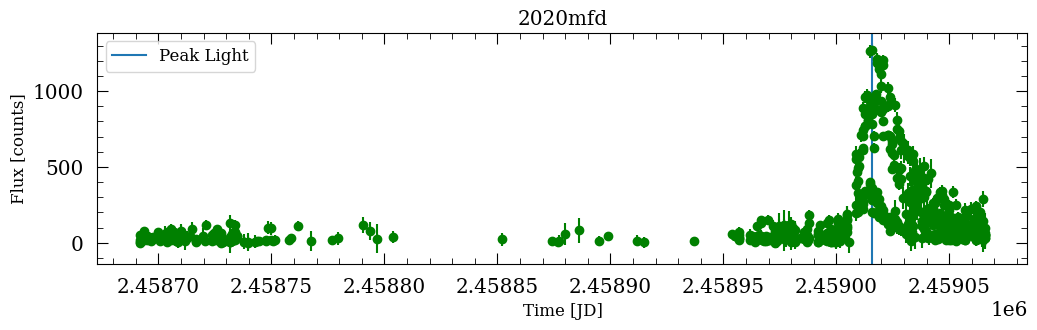

|---------------------------|
 Run-time:  3.1258 seconds
|---------------------------|


In [704]:
""" MAIN """
if __name__ == '__main__':
    # NOTES
        # Full start-up is ~15 minutes

    # Runtime tracker
    start = time.time()

    # Recovering vital directories
    recover_dir()

    # Workflow select
    # Burns_process()
    # ATLAS_process()
    ZTF_process()
    # test_realm()

    print('|---------------------------|\n Run-time: ', round(time.time()-start, 4), 'seconds\n|---------------------------|')